In [70]:
!pip install neurokit2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [165]:
from neurokit2.hrv.hrv_utils import _hrv_sanitize_input, _hrv_get_rri
from neurokit2.signal.signal_power import _signal_power_instant_plot, signal_power
from neurokit2.signal.signal_psd import signal_psd
from neurokit2.signal import signal_interpolate

import neurokit2 as nk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [166]:
#sampling_rate = 100
#duration = 300
#ecg = nk.ecg_simulate(duration=duration, sampling_rate=sampling_rate)
#signals, info = nk.ecg.ecg_process(ecg, sampling_rate=sampling_rate)

In [207]:
# real data is probably better
data = nk.data("bio_resting_8min_100hz")
sampling_rate = 100
duration = 300
start = 150
ecg = data["ECG"].values[sampling_rate*start:sampling_rate*(start + duration)]
signals, info = nk.ecg.ecg_process(ecg, sampling_rate=sampling_rate)

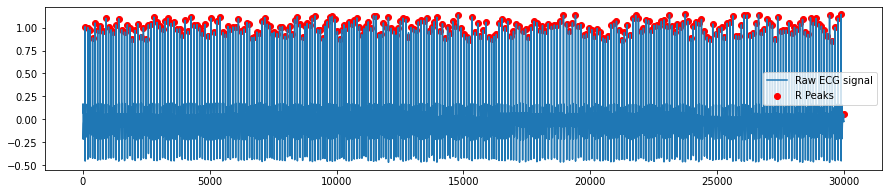

In [208]:
plt.figure(figsize=(15,3))
plt.plot(ecg)
plt.scatter(info["ECG_R_Peaks"], ecg[info["ECG_R_Peaks"]], color="red")
plt.legend(["Raw ECG signal", "R Peaks"])
plt.show()

In [209]:
peaks = info["ECG_R_Peaks"]

In [210]:
sampling_rate = 100

In [211]:
def _hrv_frequency_show(
    rri,
    out_bands,
    ulf=(0, 0.0033),
    vlf=(0.0033, 0.04),
    lf=(0.04, 0.15),
    hf=(0.15, 0.4),
    vhf=(0.4, 0.5),
    sampling_rate=1000,
    psd_method="welch",
    order_criteria=None,
    normalize=True,
    max_frequency=0.5,
    **kwargs
):

    if "ax" in kwargs:
        ax = kwargs.get("ax")
        kwargs.pop("ax")
    else:
        __, ax = plt.subplots()

    frequency_band = [ulf, vlf, lf, hf, vhf]
    for i in range(len(frequency_band)):  # pylint: disable=C0200
        min_frequency = frequency_band[i][0]
        if min_frequency == 0:
            min_frequency = 0.001  # sanitize lowest frequency

        window_length = int((2 / min_frequency) * sampling_rate)
        if window_length <= len(rri) / 2:
            break

    psd = signal_psd(
        rri,
        sampling_rate=sampling_rate,
        show=False,
        min_frequency=min_frequency,
        method=psd_method,
        max_frequency=max_frequency,
        order_criteria=order_criteria,
        normalize=normalize,
    )

    _signal_power_instant_plot(psd, out_bands, frequency_band, ax=ax)


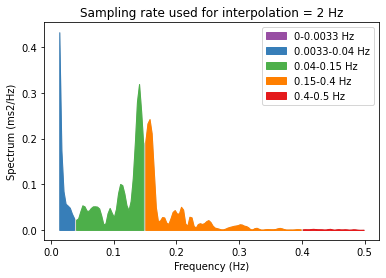

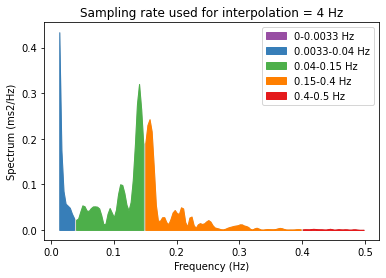

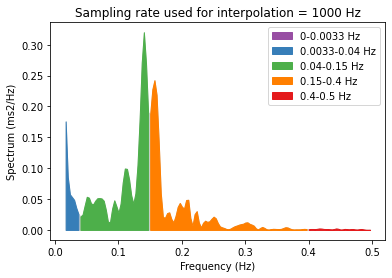

In [212]:
for new_sampling_rate in [2, 4, 1000]:
  sampling_rate = 100

  peak_time = peaks / sampling_rate
  rri = np.diff(peak_time) * 1000
  rri_time = peak_time[1:]
  orig_rri = rri.copy()
  orig_rri_time = rri_time.copy()

  # Compute length of interpolated heart period signal at requested sampling rate.
  x_new = np.arange(int(rri_time[-1]*new_sampling_rate))/new_sampling_rate

  rri = signal_interpolate(
      rri_time,  # Skip first peak since it has no corresponding element in heart_period
      rri,
      x_new=x_new,
  )
  rri_time = x_new

  ulf=(0, 0.0033)
  vlf=(0.0033, 0.04)
  lf=(0.04, 0.15)
  hf=(0.15, 0.4)
  vhf=(0.4, 0.5)
  psd_method="welch"
  show=True
  silent=True
  normalize=True
  order_criteria=None
  frequency_band = [ulf, vlf, lf, hf, vhf]

  # Find maximum frequency
  max_frequency = np.max([np.max(i) for i in frequency_band])

  power = signal_power(
      rri,
      frequency_band=frequency_band,
      sampling_rate=new_sampling_rate,
      method=psd_method,
      max_frequency=max_frequency,
      show=True,
      normalize=normalize,
      order_criteria=order_criteria,
  )
  plt.title("Sampling rate used for interpolation = " + str(new_sampling_rate) + " Hz")
  plt.show()

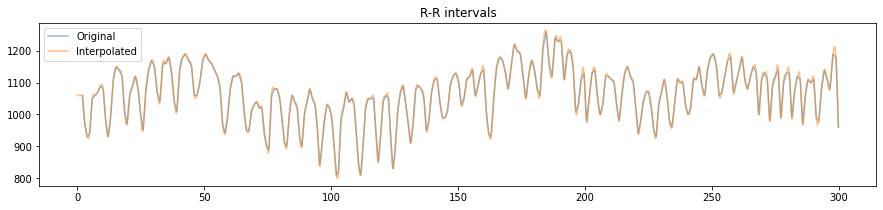

In [213]:
plt.figure(figsize=(15,3))
plt.plot(orig_rri_time, orig_rri, alpha=0.5)
plt.plot(rri_time, rri, alpha=0.5)
plt.title("R-R intervals")
plt.legend(["Original", "Interpolated"])
plt.show()